In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"healreaper","key":"7f962a9a580422bf92d8da4d70e42b9e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d hrishabhnayal/crop-data

Dataset URL: https://www.kaggle.com/datasets/hrishabhnayal/crop-data
License(s): unknown
 99% 1.98G/2.01G [00:13<00:00, 254MB/s]
100% 2.01G/2.01G [00:13<00:00, 163MB/s]


In [ ]:
!unzip -q crop-data.zip

In [ ]:
!ls -l

total 2106700
-rw-r--r-- 1 root root 2157240991 Apr 11  2024  crop-data.zip
-rw-r--r-- 1 root root         66 Jun 26 16:46  kaggle.json
drwxr-xr-x 1 root root       4096 Jun 25 13:36  sample_data
drwxr-xr-x 4 root root       4096 Jun 26 16:47 'Ultimate Crop Disease Dataet'


In [ ]:
!mv 'Ultimate Crop Disease Dataet' 'Ultimate Crop Disease Dataset'

In [ ]:
original_data = "Ultimate Crop Disease Dataset/train"

In [ ]:
# Check contents
import os
print("✅ Classes:", os.listdir("Ultimate Crop Disease Dataset/train"))

✅ Classes: ['Tomato_verticulium wilt', 'Cashew_gumosis', 'Cashew_healthy', 'Cassava_brown spot', 'Cashew_anthracnose', 'Rice_brown_spot', 'Rice_bacterial_leaf_streak', 'Maize_leaf beetle', 'Tomato_leaf blight', 'Cassava_green mite', 'Maize_streak virus', 'Rice_bacterial_leaf_blight', 'Cassava_healthy', 'Cassava_mosaic', 'Rice_healthy', 'Rice_tungro', 'Tomato_septoria leaf spot', 'Maize_leaf blight', 'Cashew_leaf miner', 'Tomato_leaf curl', 'Tomato_healthy', 'Maize_fall armyworm', 'Maize_leaf spot', 'Rice_dead_heart', 'Rice_downy_mildew', 'Rice_bacterial_panicle_blight', 'Rice_blast', 'Rice_hispa', 'Maize_grasshoper', 'Maize_healthy', 'Cashew_red rust', 'Cassava_bacterial blight']


In [ ]:
# ✅ PART 1: Imports & Config
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ✅ Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ✅ Define all classes and filter rice-specific ones
all_classes = ['Maize_grasshoper', 'Cashew_leaf miner', 'Rice_blast', 'Rice_hispa', 'Cashew_gumosis',
               'Maize_fall armyworm', 'Cassava_green mite', 'Cashew_healthy', 'Cassava_brown spot',
               'Tomato_leaf blight', 'Tomato_septoria leaf spot', 'Rice_brown_spot',
               'Rice_bacterial_leaf_blight', 'Cashew_red rust', 'Tomato_healthy',
               'Cassava_bacterial blight', 'Maize_leaf beetle', 'Maize_leaf spot', 'Rice_healthy',
               'Cassava_mosaic', 'Tomato_leaf curl', 'Rice_bacterial_panicle_blight',
               'Cashew_anthracnose', 'Cassava_healthy', 'Maize_streak virus', 'Rice_tungro',
               'Rice_dead_heart', 'Rice_downy_mildew', 'Maize_leaf blight', 'Maize_healthy',
               'Rice_bacterial_leaf_streak', 'Tomato_verticulium wilt']

rice_classes = [cls for cls in all_classes if "Rice" in cls]
print("🌾 Rice Classes Only:", rice_classes)

🌾 Rice Classes Only: ['Rice_blast', 'Rice_hispa', 'Rice_brown_spot', 'Rice_bacterial_leaf_blight', 'Rice_healthy', 'Rice_bacterial_panicle_blight', 'Rice_tungro', 'Rice_dead_heart', 'Rice_downy_mildew', 'Rice_bacterial_leaf_streak']


In [ ]:
# ✅ PART 2: Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# ✅ PART 3: Dataset Loading
train_dataset = datasets.ImageFolder("crop_dataset/train", transform=train_transform)
val_dataset = datasets.ImageFolder("crop_dataset/val", transform=val_transform)

# Filter datasets to include only rice classes
train_dataset.samples = [s for s in train_dataset.samples if any(r in s[0] for r in rice_classes)]
val_dataset.samples = [s for s in val_dataset.samples if any(r in s[0] for r in rice_classes)]

# Remap class indices to consecutive integers for rice classes
label_mapping = {cls_name: idx for idx, cls_name in enumerate(sorted(set(cls for path, _ in train_dataset.samples for cls in rice_classes if cls in path)))}

def remap_samples(samples):
    return [(path, label_mapping[next(cls for cls in rice_classes if cls in path)]) for path, _ in samples]

train_dataset.samples = remap_samples(train_dataset.samples)
val_dataset.samples = remap_samples(val_dataset.samples)
train_dataset.targets = [label for _, label in train_dataset.samples]
val_dataset.targets = [label for _, label in val_dataset.samples]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

class_names = list(label_mapping.keys())
print("\u2705 Classes (Rice only):", class_names)

✅ Classes (Rice only): ['Rice_bacterial_leaf_blight', 'Rice_bacterial_leaf_streak', 'Rice_bacterial_panicle_blight', 'Rice_blast', 'Rice_brown_spot', 'Rice_dead_heart', 'Rice_downy_mildew', 'Rice_healthy', 'Rice_hispa', 'Rice_tungro']


In [ ]:
# ✅ PART 4: Model Setup
model = models.resnet18(pretrained=True)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(class_names))
)
model = model.to(device)

In [ ]:
# ✅ PART 5: Loss, Optimizer, Class Weights
class_weights = compute_class_weight('balanced', classes=np.arange(len(class_names)), y=[s[1] for s in train_dataset.samples])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [ ]:
# ✅ PART 6: Training Function
def train_model(model, epochs=30, patience=5):
    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            loader = train_loader if phase == 'train' else val_loader

            running_loss, correct = 0.0, 0
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = correct.double() / len(loader.dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_weights = copy.deepcopy(model.state_dict())
                    counter = 0
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"\n⏹ Early stopping at epoch {epoch+1}")
                        model.load_state_dict(best_weights)
                        return model, history

    print(f"\n✅ Best Val Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_weights)
    return model, history


Epoch 1/20
train Loss: 1.8002 Acc: 0.4690
val Loss: 1.5721 Acc: 0.6601

Epoch 2/20
train Loss: 1.4977 Acc: 0.6383
val Loss: 1.3739 Acc: 0.7512

Epoch 3/20
train Loss: 1.3737 Acc: 0.6839
val Loss: 1.3077 Acc: 0.7885

Epoch 4/20
train Loss: 1.2838 Acc: 0.7352
val Loss: 1.2871 Acc: 0.8002

Epoch 5/20
train Loss: 1.2270 Acc: 0.7522
val Loss: 1.2113 Acc: 0.8455

Epoch 6/20
train Loss: 1.1809 Acc: 0.7726
val Loss: 1.1520 Acc: 0.8695

Epoch 7/20
train Loss: 1.1594 Acc: 0.7821
val Loss: 1.1066 Acc: 0.8929

Epoch 8/20
train Loss: 1.1335 Acc: 0.8014
val Loss: 1.1105 Acc: 0.8785

Epoch 9/20
train Loss: 1.0988 Acc: 0.8158
val Loss: 1.0938 Acc: 0.8929

Epoch 10/20
train Loss: 1.0744 Acc: 0.8209
val Loss: 1.0780 Acc: 0.8897

Epoch 11/20
train Loss: 1.0510 Acc: 0.8376
val Loss: 1.0746 Acc: 0.8956

Epoch 12/20
train Loss: 1.0293 Acc: 0.8436
val Loss: 1.1094 Acc: 0.8769

Epoch 13/20
train Loss: 1.0313 Acc: 0.8402
val Loss: 1.0887 Acc: 0.8876

Epoch 14/20
train Loss: 1.0098 Acc: 0.8519
val Loss: 1.0709

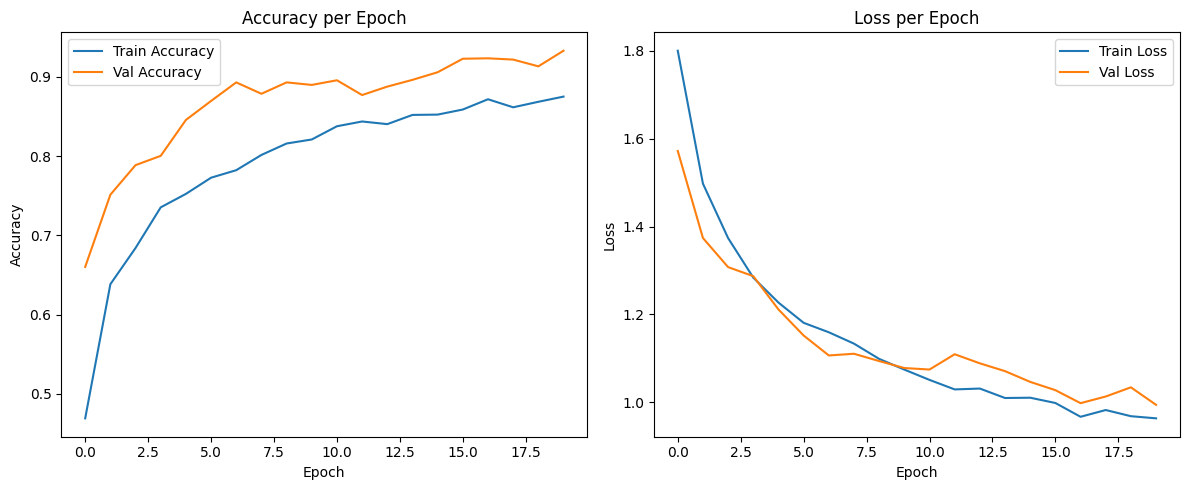

In [ ]:
# ✅ PART 7: Train & Plot
model, history = train_model(model, epochs=20, patience=5)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def predict_image(img_path, model, class_names):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)

    pred_class = class_names[pred.item()]
    print(f"🌾 Prediction: {pred_class}")

    # Show image
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class}")
    plt.axis("off")
    plt.show()

    return pred_class

Saving images.jpeg to images (2).jpeg
🌾 Prediction: Rice_brown_spot


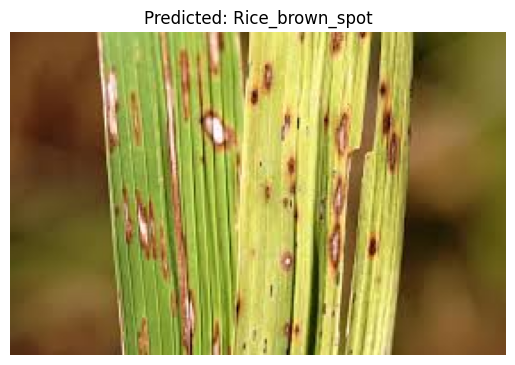


🔍 Getting cure for: Rice_brown_spot
1. Apply fungicides like mancozeb.
2. Use potassium-rich fertilizer.
3. Improve drainage and avoid nutrient stress.


In [ ]:
# Upload image
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Predict the disease class
predicted_disease = predict_image(img_path, model, train_dataset.classes)

# Get cure
print(f"\n🔍 Getting cure for: {predicted_disease}")
cure = predefined_cures.get(predicted_disease) or ask_gemini_short(predicted_disease)
print(cure)
